In [1]:
%matplotlib inline
import random
import os
import re
import unicodedata
import io
import time

import numpy as np
import matplotlib.pyplot as plt

In [2]:
import torch
import torch.nn as nn
import torch.optim as optim
import torch.nn.functional as F
from torch.autograd import Variable

In [3]:
SOS_TOKEN = 1
EOS_TOKEN = 2

In [4]:
class Lang:
    def __init__(self, name):
        self.name = name
        self.word2idx = {'SOS' : SOS_TOKEN, 'EOS' : EOS_TOKEN}
        self.idx2word = {v : k for k,v in self.word2idx.items()}
        self.word2cnt = {}
        self.idx = 3
        
    def add_word(self, w):
        if w not in self.word2idx:
            self.word2idx[w] = self.idx
            self.idx2word[self.idx] = w
            self.word2cnt[w] = 1
            self.idx += 1
        else:
            self.word2cnt[w] += 1
    
    def add_sentence(self, s):
#         s = s.lower().strip()    # just to be sure
        for w in s.split(' '):
            self.add_word(w)

In [5]:
# Turn a Unicode string to plain ASCII, thanks to
# http://stackoverflow.com/a/518232/2809427
def unicode_to_ascii(s):                                      #? why convert 2 ascii
    return ''.join(c for c in unicodedata.normalize('NFD', s) if unicodedata.category(c) != 'Mn')

In [6]:
x = 'addas.!?'
x = re.sub(r"[^A-Za-z0-9,.!\/'+=]", " ", x)
x = re.sub(r"\.", r" . ", x)
x = re.sub(r"!", r" ! ", x)
x = re.sub(r"\?", r" ? ", x)

x

'addas .  !  '

In [9]:
# Lowercase, trim, and remove non-letter characters
def normalize_string(s):
    s = unicode_to_ascii(s.lower().strip())
    if s[-1] in ['.', '?', '!']:
        s = s[:-1] + ' ' + s[-1]
    
#     s = s.lower().strip()
    s = re.sub(r"[^A-Za-z0-9,.!\?\/'+=]", " ", s)
    s = re.sub(r"!", " ! ", s)
    s = re.sub(r"\.", " . ", s)
#     s = re.sub(r"\?", " ? ", s)
    s = re.sub(r"what's", "what is ", s)
    s = re.sub(r"it's", r"it is", s)
    s = re.sub(r"\'s", " ", s)
    s = re.sub(r" n ", " and ", s)
    s = re.sub(r"\'ve", " have ", s)
    s = re.sub(r"can't", "cannot ", s)
    s = re.sub(r"n't", " not ", s)
    s = re.sub(r"i'm", "i am ", s)
    s = re.sub(r"\'re", " are ", s)
    s = re.sub(r"\'d", " would ", s)
    s = re.sub(r"\'ll", " will ", s)
    s = re.sub(r",", " ", s)
    s = re.sub(r"\/", " ", s)
    s = re.sub(r"\^", " ^ ", s)
    s = re.sub(r"\+", " + ", s)
    s = re.sub(r"\-", " - ", s)
    s = re.sub(r"\=", " = ", s)
    s = re.sub(r"'", " ", s)
    s = re.sub(r":", " : ", s)
    s = re.sub(' +', ' ', s)
    
    s = s.strip()
    
    return s

In [10]:
x = 'When I was a kid, touching bugs didn\'t bother me a bit. Now I can hardly stand looking at pictures of them.'
normalize_string(x)

'when i was a kid touching bugs did not bother me a bit . now i can hardly stand looking at pictures of them .'

In [11]:
def indent_end(s):
    if s[-1] in ['|', '?', '!', '।']:
        s = s[:-1] + ' ' + s[-1]
    return s

In [12]:
def read_langs(lang1, lang2, reverse = False):
    data = io.open(f'{lang1}-{lang2}/{lang1}.txt').read().strip().split('\n')
    pairs = [[normalize_string(s) for s in line.split('\t')] for line in data]
    pairs = []
    for line in data:
        s = line.split('\t')
        pairs.append([normalize_string(s[0]), indent_end(s[1])])
    
    if reverse:
        pairs = [list(reversed(pair)) for pair in pairs]
        input_lang = Lang(lang2)
        output_lang = Lang(lang1)
    else:
        input_lang = Lang(lang1)
        output_lang = Lang(lang2)
    
    return input_lang, output_lang, pairs

In [13]:
def prepare_data(lang1, lang2, reverse = False):
    input_lang, output_lang, pairs = read_langs(lang1, lang2, reverse)
    for pair in pairs:
        input_lang.add_sentence(pair[0])
        output_lang.add_sentence(pair[1])
    
    print("Read %s sentence pairs" % len(pairs))
    print(random.choice(pairs))
    print(random.choice(pairs))
    
    print("Counting words...")
    print(input_lang.name, input_lang.idx)
    print(output_lang.name, output_lang.idx)
    return input_lang, output_lang, pairs

input_lang, output_lang, pairs = prepare_data('hin', 'eng', False)
print(random.choice(pairs))

Read 2867 sentence pairs
['wooden buildings catch fire easily .', 'लकड़ी से बनी इमारतों में आग आसानी से लग जाती है ।']
['i am bored .', 'मैं बोर हो रहा हूँ ।']
Counting words...
hin 2364
eng 2970
['the air conditioner makes too much noise .', 'एसी बहुत आवाज़ करता है ।']


In [14]:
MAX_LENGTH = max(len(pair[0]) for pair in pairs)
MAX_LENGTH

127

## Embedding

In [15]:
sorted(output_lang.word2idx.items(), key = lambda x : x[1])[-10:]

[('ट्रेफ़िक', 2960),
 ('हादसे', 2961),
 ('कीड़ों', 2962),
 ('परेशानी', 2963),
 ('जिस', 2964),
 ('करें।', 2965),
 ('दूसरी', 2966),
 ('अनुवादों', 2967),
 ('प्रभावित', 2968),
 ('दें', 2969)]

In [16]:
sorted(input_lang.word2idx.items(), key = lambda x : x[1])[-10:]

[('worst', 2354),
 ('form', 2355),
 ('kid', 2356),
 ('touching', 2357),
 ('bugs', 2358),
 ('bother', 2359),
 ('translation', 2360),
 ('translating', 2361),
 ('translations', 2362),
 ('influence', 2363)]

In [17]:
sorted(input_lang.word2idx.items(), key = lambda x : x[1])[:10]

[('SOS', 1),
 ('EOS', 2),
 ('wow', 3),
 ('!', 4),
 ('help', 5),
 ('jump', 6),
 ('.', 7),
 ('hello', 8),
 ('cheers', 9),
 ('got', 10)]

In [18]:
sorted(input_lang.word2cnt.items(), key = lambda x : x[1])[-10:]

[('not', 298),
 ('he', 393),
 ('a', 418),
 ('?', 445),
 ('is', 504),
 ('you', 544),
 ('to', 553),
 ('i', 748),
 ('the', 792),
 ('.', 2404)]

In [19]:
sorted(input_lang.word2cnt.items(), key = lambda x : x[1])[:10]

[('wow', 1),
 ('awesome', 1),
 ('goodbye', 1),
 ('full', 1),
 ('fantastic', 1),
 ('fainted', 1),
 ('fear', 1),
 ('definitely', 1),
 ('burns', 1),
 ('easter', 1)]

In [20]:
eng_vocab_size = input_lang.idx + 1

In [21]:
hin_vocab_size = output_lang.idx + 1

In [22]:
eng_vocab_size, hin_vocab_size

(2365, 2971)

## Encoder

![](encoder.png)

In [24]:
class EncoderRNN(nn.Module):
    def __init__(self, input_size, embedding_dim, hidden_size, n_layers):
        super(EncoderRNN, self).__init__()
        
        self.hidden_size = hidden_size
        self.n_layers = n_layers
        
        self.embedding = nn.Embedding(input_size, embedding_dim)
        self.gru = nn.GRU(embedding_dim, hidden_size)
        
    def forward(self, x, hidden):
        seq_len = len(x)
        embedded = nn.Embedding(x).view(1, seq_len, -1)
        
        output, hidden = self.gru(embedded, hidden)
        
        return output, hidden
    
    def initHidden(self):
        hidden = torch.zeros(self.n_layers, 1, self.hidden_size)
        return hidden

## Decoder

![](AttnDecoderRNN.png)

Interpreting the Luong et al. model(s)
Effective Approaches to Attention-based Neural Machine Translation by Luong et al. describe a few more attention models that offer improvements and simplifications. They describe a few "global attention" models, the distinction between them being the way the attention scores are calculated.

The general form of the attention calculation relies on the target (decoder) side hidden state and corresponding source (encoder) side state, normalized over all states to get values summing to 1:

$$
a_t(s) = align(h_t, \bar h_s)  = \dfrac{exp(score(h_t, \bar h_s))}{\sum_{s'} exp(score(h_t, \bar h_{s'}))}
$$
The specific "score" function that compares two states is either dot, a simple dot product between the states; general, a a dot product between the decoder hidden state and a linear transform of the encoder state; or concat, a dot product between a new parameter $v_a$ and a linear transform of the states concatenated together.

$$
score(h_t, \bar h_s) =
\begin{cases}
h_t ^\top \bar h_s &amp; dot \\
h_t ^\top \textbf{W}_a \bar h_s &amp; general \\
v_a ^\top \textbf{W}_a [ h_t ; \bar h_s ] &amp; concat
\end{cases}
$$
The modular definition of these scoring functions gives us an opportunity to build specific attention module that can switch between the different score methods. The input to this module is always the hidden state (of the decoder RNN) and set of encoder outputs.

In [ ]:
class Attn(nn.Module):
    def __init__(self, hidden_size, method = 'concat', max_length = MAX_LENGTH):
        super(Attn, self).__init__()
        
        self.hidden_size = hidden_size
        self.method = method
        
        self.attn = nn.Linear(2 * hidden_size, hidden_size)
        self.v = nn.Parameter(torch.rand(hidden_size))
        stdev = 1./math.sqrt(self.v.size(0)) 
        self.v.data.normal_(mean = 0, std = stdev)
        
#     def forward(self, )

In [121]:
hidden = torch.rand(1, 256)
enc = torch.rand(127, 1, 256)
# torch.cat((hidden, enc), dim = 0).shape

In [122]:
H = hidden.repeat(127, 1, 1).transpose(0, 1)
H.shape

torch.Size([1, 127, 256])

In [123]:
enc_trans = enc.transpose(0, 1)
enc_trans.shape

torch.Size([1, 127, 256])

In [124]:
torch.cat((H, enc_trans), dim = 2).shape

torch.Size([1, 127, 512])

In [180]:
class Attn(nn.Module):
    def __init__(self, hidden_size, method = 'concat', max_length = MAX_LENGTH):
        super(Attn, self).__init__()
        self.method = method
        self.hidden_size = hidden_size
        self.max_length = max_length
        
        if self.method == 'general':
            self.attn = nn.Linear(hidden_size, hidden_size)
            
        if self.method == 'concat':
            self.attn = nn.Linear(2 * hidden_size, hidden_size)
            self.v = nn.Parameter(torch.rand(hidden_size))
            stdev = 1. / math.sqrt(self.v.size(0))
            self.v.data.normal_(mean = 0, std = stdev)
            
    def forward(self, hidden, encoder_outputs):
        '''
        :param hidden: 
            previous hidden state of the decoder, in shape (B, H) as hidden[-1]
        :param encoder_outputs:
            encoder outputs from Encoder, in shape (T, B, H)
        :return
            attention wts in shape (B, T)
        '''
        # B = 1 (for us)
        
        H = hidden.repeat(self.max_length, 1, 1).transpose(0, 1)        # H -> [T, B, H], after transpose [B, T, H]
        encoder_outputs = encoder_outputs.transpose(0, 1)               # encoder_outputs -> [B, T, H]
        attn_energies = self.score(H, encoder_outputs)                  # compute attention score
        return F.softmax(attn_energies).unsqueeze(1)                    # normalize with softmax
    
    def score(self, hidden, encoder_outputs):         
        if self.method == 'dot':         #??NOT WORKING
            energy = hidden.dot(encoder_output)     # hidden -> [n_layers * directional, B, H], encoder_output -> [T, B, H]
            return energy
        
        if self.method == 'general':     #??NOT WORKING
            energy = self.attn(encoder_output)
            energy = hidden.dot(energy)
            return energy
            
        if self.method == 'concat':
            energy = torch.tanh(self.attn(torch.cat([hidden, encoder_outputs], 2))) # [B, T, 2H] -> [B, T, H]
            energy = energy.transpose(2,1)       # [B, H, T]
            v = self.v.repeat(encoder_outputs.data.shape[0], 1).unsqueeze(1)    #[B, 1, H]
            energy = torch.bmm(v, energy)        # [B, 1, T]
            return energy.squeeze(1)             # [B, T]

![](BahdanauAttention.png)

In [174]:
class BahdanauAttnDecoderRNN(nn.Module):
    def __init__(self, hidden_size, output_size, n_layers, dropout_p, max_length = MAX_LENGTH):
        super(BahdanauAttnDecoderRNN, self).__init__()
        self.hidden_size = hidden_size
        self.n_layers = n_layers
        
        self.embedding = nn.Embedding(output_size, hidden_size)
        self.dropout = nn.Dropout(p = dropout_p)
        self.attn = Attn(hidden_size, method = 'concat')
#         self.attn = nn.Linear(2 * hidden_size, max_length)
        self.attn_combine = nn.Linear(2 * hidden_size, hidden_size)
        self.gru = nn.GRU(hidden_size, hidden_size, n_layers)
        self.output = nn.Linear(hidden_size, output_size)
        
    def forward(self, x, hidden, encoder_outputs):             # encoder_outputs => (max_length, encoder.hidden_size)
        '''
        :param word_input:
            word input for current time step, in shape (B)
        :param last_hidden:
            last hidden stat of the decoder, in shape (layers*direction, B, H)
        :param encoder_outputs:
            encoder outputs in shape (T, B, H)
        :return
            decoder output
        Note: we run this one step at a time i.e. you should use a outer loop 
            to process the whole sequence
        Tip(update):
        EncoderRNN may be bidirectional or have multiple layers, so the shape of hidden states can be 
        different from that of DecoderRNN
        You may have to manually guarantee that they have the same dimension outside this function,
        e.g, select the encoder hidden state of the foward/backward pass.
        '''
        embedded = self.embedding(x).view(1, 1, -1)              #  (1, B, V)
        embedded = self.dropout(embedded)
        
#         attn_weights = F.softmax(self.attn(torch.cat((hidden[-1], encoder_outputs), dim = 1)), dim = 1)
        attn_weights = self.attn(hidden[-1], encoder_outputs)        # attn_weights -> [B, T]
    
        context = attn_weights.bmm(encoder_outputs.transpose(0, 1))          # context -> [B, 1, V]
        context = context.transpose(0, 1)                                    # context -> [1, B, V]
         
        attn_combine = self.attn_combine(torch.cat((embedded, context), dim = 2))
        output = F.relu(attn_combine)
        
        output, hidden = self.gru(output, hidden)
        
        output = F.log_softmax(self.output(output[0]), dim = 1)
        
        return output, hidden, attn_weights
        
    def initHidden(self):
        return torch.zeros(self.n_layers, 1, self.hidden_size)

### Preparing training data

In [127]:
def indexes_from_sentence(lang, sentence):
    return [lang.word2idx[word] for word in sentence.split(' ')]

def tensor_from_sentence(lang, sentence):
    indexes = indexes_from_sentence(lang, sentence)
    indexes.append(EOS_TOKEN)
    return torch.tensor(indexes, dtype = torch.long).view(-1, 1)

def tensors_from_pair(pair):
    input_tensor = tensor_from_sentence(input_lang, pair[0])
    target_tensor = tensor_from_sentence(output_lang, pair[1])
    
    return input_tensor, target_tensor

In [128]:
tensors_from_pair(pairs[0])

(tensor([[3],
         [4],
         [2]]), tensor([[3],
         [4],
         [2]]))

**Teacher forcing** is the concept of using the real target outputs as each next input, instead of using the decoder’s guess as the next input. Using teacher forcing causes it to converge faster but when the trained network is exploited, it may exhibit instability.

In [130]:
teacher_forcing_ratio = 0.6
clip = 5.0

In [182]:
def train(input_tensor, target_tensor, encoder, decoder, encoder_optimizer, decoder_optimizer, criterion, max_length = MAX_LENGTH):    
    encoder_optimizer.zero_grad()
    decoder_optimizer.zero_grad()
    
    input_length = input_tensor.size(0)
    target_length = target_tensor.size(0)
    
    encoder_outputs = torch.zeros(max_length, 1, encoder.hidden_size)
    
#     for ei in range(input_length):
#         encoder_output, encoder_hidden = encoder(input_tensor[ei], encoder_hidden)
#         encoder_outputs[ei] = encoder_output[0]

    # Run words through encoder
    encoder_hidden = encoder.initHidden()
    encoder_output, encoder_hidden = encoder(input_tensor, encoder_hidden)
    encoder_outputs[:encoder_output.size(0), :, :] = encoder_output
#     print(encoder_outputs.shape)
    
    loss = 0
    
    decoder_hidden = encoder_hidden
    
    decoder_input = torch.tensor([[SOS_TOKEN]], dtype = torch.long)
    
    for di in range(target_length):
        decoder_output, decoder_hidden, decoder_attn = decoder(decoder_input, decoder_hidden, encoder_outputs)
        
        use_teacher_forcing = True if random.random() < teacher_forcing_ratio else False
        
        if use_teacher_forcing:
            decoder_input = target_tensor[di]
            loss += criterion(decoder_output, target_tensor[di])
        else:
            topv, topi = decoder_output.topk(1)
            decoder_input = topi.squeeze().detach()             # detach from history as input
            
            loss += criterion(decoder_output, target_tensor[di])
        
        if decoder_input.item() == EOS_TOKEN:
            break
    
    loss.backward()
    
    torch.nn.utils.clip_grad_norm_(encoder.parameters(), max_norm = clip)
    torch.nn.utils.clip_grad_norm_(decoder.parameters(), max_norm = clip)    
    
    encoder_optimizer.step()
    decoder_optimizer.step()
    
    return loss.item() / target_length

#### This is a helper function to print time elapsed and estimated time remaining given the current time and progress %.

In [132]:
import time
import math


def asMinutes(s):
    m = math.floor(s / 60)
    s -= m * 60
    return '%dm %ds' % (m, s)


def timeSince(since, percent):
    now = time.time()
    s = now - since
    es = s / (percent)
    rs = es - s
    return '%s (- %s)' % (asMinutes(s), asMinutes(rs))

#### The whole training process looks like this:
* Start a timer
* Initialize optimizers and criterion
* Create set of training pairs
* Start empty losses array for plotting

In [133]:
def train_iters(encoder, decoder, n_iters, print_every = 1000, plot_every = 100, learning_rate = 0.001):
    start = time.time()
    plot_losses = []
    print_loss_total = 0  # Reset after every print_every
    plot_loss_total = 0  # Reset after every plot_every
    
    encoder_optimizer = optim.Adam(encoder.parameters(), lr = learning_rate)
    decoder_optimizer = optim.Adam(decoder.parameters(), lr = learning_rate)
    
    training_pairs = [tensors_from_pair(random.choice(pairs)) for _ in range(n_iters)]
    
    criterion = nn.NLLLoss()
    
    for n_iter in range(1, n_iters + 1):
        training_pair = training_pairs[n_iter - 1]
        input_tensor = training_pair[0]
        target_tensor = training_pair[1]

        loss = train(input_tensor, target_tensor, encoder,
                     decoder, encoder_optimizer, decoder_optimizer, criterion)
        
        plot_losses.append(loss)
        
        print_loss_total += loss
        plot_loss_total += loss

        if n_iter % print_every == 0:
            print_loss_avg = print_loss_total / print_every
            print_loss_total = 0
            print('%s (%d %d%%) %.4f' % (timeSince(start, n_iter / n_iters),
                                         n_iter, n_iter / n_iters * 100, print_loss_avg))

        if n_iter % plot_every == 0:
            plot_loss_avg = plot_loss_total / plot_every
            plot_losses.append(plot_loss_avg)
            plot_loss_total = 0

    show_plot(plot_losses)

In [134]:
import matplotlib.pyplot as plt
import matplotlib.ticker as ticker
import numpy as np


def show_plot(points):
    plt.figure()
    fig, ax = plt.subplots()
    # this locator puts ticks at regular intervals
    loc = ticker.MultipleLocator(base=0.2)
    ax.yaxis.set_major_locator(loc)
    plt.plot(points)

In [188]:
def evaluate(encoder, decoder, sentence, max_length = MAX_LENGTH):
    with torch.no_grad():
        input_tensor = tensor_from_sentence(input_lang, sentence)
        input_length = input_tensor.size()[0]
        encoder_hidden = encoder.initHidden()

        encoder_outputs = torch.zeros(max_length, 1, encoder.hidden_size)

#         for ei in range(input_length):
#             encoder_output, encoder_hidden = encoder(input_tensor[ei],
#                                                      encoder_hidden)
#             encoder_outputs[ei] += encoder_output[0, 0]
        
        # Run words through encoder
        encoder_hidden = encoder.initHidden()
        encoder_output, encoder_hidden = encoder(input_tensor, encoder_hidden)
        encoder_outputs[:encoder_output.size(0), :, :] = encoder_output
    
        decoder_input = torch.tensor([[SOS_TOKEN]])  # SOS

        decoder_hidden = encoder_hidden
        
        decoded_words = []
        decoder_attentions = torch.zeros(max_length, max_length)

        for di in range(max_length):
            decoder_output, decoder_hidden, decoder_attention = decoder(
                decoder_input, decoder_hidden, encoder_outputs)
            decoder_attentions[di] = decoder_attention.data
            topv, topi = decoder_output.data.topk(1)
            if topi.item() == EOS_TOKEN:
                decoded_words.append('<EOS>')
                break
            else:
                decoded_words.append(output_lang.idx2word[topi.item()])

            decoder_input = topi.squeeze().detach()

        return decoded_words, decoder_attentions[:di + 1]

In [136]:
def evaluate_randomly(encoder, decoder, n=10):
    for i in range(n):
        pair = random.choice(pairs)
        print('>', pair[0])
        print('=', pair[1])
        output_words, attentions = evaluate(encoder, decoder, pair[0])
        output_sentence = ' '.join(output_words)
        print('<', output_sentence)
        print('')

In [183]:
hidden_size = 256
encoder = EncoderRNN(eng_vocab_size, hidden_size, 1)
attn_decoder = BahdanauAttnDecoderRNN(hidden_size, hin_vocab_size, 1, dropout_p = 0.1)

train_iters(encoder, attn_decoder, 100000, print_every = 1000)

/home/akash/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:31: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.


1m 36s (- 159m 30s) (1000 1%) 4.9106
3m 31s (- 172m 19s) (2000 2%) 4.3582
5m 18s (- 171m 52s) (3000 3%) 3.8928
7m 7s (- 171m 4s) (4000 4%) 3.3771
9m 5s (- 172m 45s) (5000 5%) 3.1241
11m 8s (- 174m 31s) (6000 6%) 2.7709
13m 21s (- 177m 23s) (7000 7%) 2.4828
15m 22s (- 176m 51s) (8000 8%) 2.3512
17m 19s (- 175m 11s) (9000 9%) 2.0611
19m 19s (- 173m 51s) (10000 10%) 1.9179
21m 16s (- 172m 9s) (11000 11%) 1.7741
23m 15s (- 170m 36s) (12000 12%) 1.6709
25m 14s (- 168m 52s) (13000 13%) 1.5095
27m 12s (- 167m 9s) (14000 14%) 1.5181
29m 11s (- 165m 27s) (15000 15%) 1.2247
31m 10s (- 163m 40s) (16000 16%) 1.3195
33m 16s (- 162m 26s) (17000 17%) 1.1914
35m 15s (- 160m 36s) (18000 18%) 1.0954
37m 14s (- 158m 47s) (19000 19%) 1.0362
39m 14s (- 156m 57s) (20000 20%) 0.9979
41m 14s (- 155m 8s) (21000 21%) 0.9994
43m 14s (- 153m 17s) (22000 22%) 0.9606
45m 14s (- 151m 26s) (23000 23%) 0.9733
47m 13s (- 149m 34s) (24000 24%) 0.9143
49m 14s (- 147m 42s) (25000 25%) 0.8312
51m 13s (- 145m 49s) (26000 26

KeyboardInterrupt: 

In [189]:
evaluate_randomly(encoder, attn_decoder)

> as soon as he finished his work he went home .
= वह अपना काम खतम करते ही घर चला गया ।
< वह अपना काम खतम करते ही घर खतम हो चला गया । <EOS>

> i doubt the truth of his statement .
= मुझे उसके बयान की सच्चाई पर शक है ।
< मुझे उसके बयान की सच्चाई पर शक है । <EOS>

> he may be rich but he is stingy .
= वह अमीर है हो है पर कंजूस भी है ।


/home/akash/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:31: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.


< वह अमीर है है है है है है है है है है है है है है है है है है । <EOS>

> i would rather not meet him .
= हो सके तो मैं उससे मिलना नहीं चाहूँगा ।
< हो सके तो मैं उसे मिलना नहीं चाहूँगी । <EOS>

> there are many old temples in kyoto .
= क्योटो में बहुत सारे पुराने मंदिर हैं ।
< क्योटो में बहुत सारे पुराने मंदिर हैं । <EOS>

> cannot you speak english ?
= तुम अंग्रेज़ी नहीं बोल सकते हो क्या ?
< तुम अंग्रेज़ी नहीं बोल सकते हो क्या ? <EOS>

> i fear so .
= खेद की बात है, लेकिन वैसा ही है ।
< मैं वैसा बात क्यों नहीं हूँ । <EOS>

> i work for a bank .
= मैं बैंक में काम करता हूँ ।
< मैं बैंक में काम करता हूँ । <EOS>

> my father spends a lot of time on his hobby .
= मेरे पिता अपने शौक पर बहुत समय खर्च करते हैं ।
< मेरे पिता अपने शौक के साथ शौक मत भूलना । <EOS>

> here please have a seat .
= यहां, बैठिये ।
< यहां, बैठिये । <EOS>



/home/akash/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:31: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.


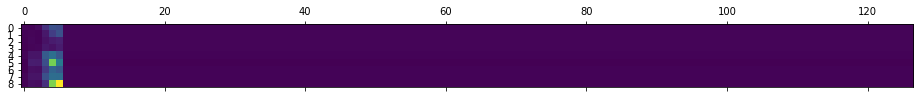

In [190]:
output_words, attentions = evaluate(
    encoder, attn_decoder, "i want a drink .")
plt.matshow(attentions.numpy())

input = wow !
output = बधाई ! <EOS>


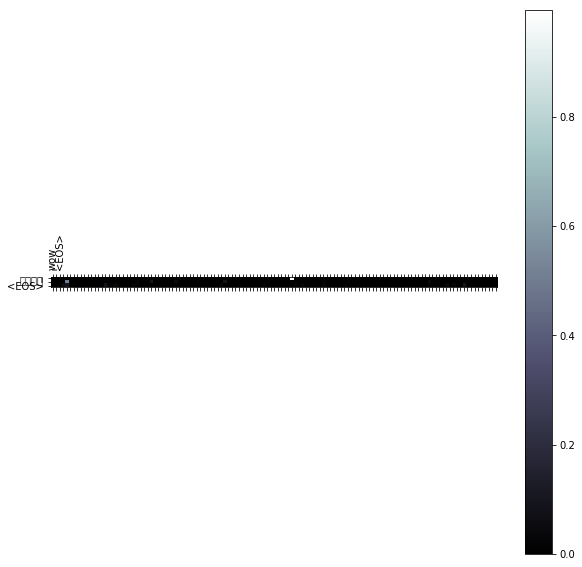

In [85]:
def showAttention(input_sentence, output_words, attentions):
    # Set up figure with colorbar
    fig = plt.figure(figsize=(10, 10))
    ax = fig.add_subplot(111)
    cax = ax.matshow(attentions.numpy(), cmap='bone')
    fig.colorbar(cax)

    # Set up axes
    ax.set_xticklabels([''] + input_sentence.split(' ') +
                       ['<EOS>'], rotation=90)
    ax.set_yticklabels([''] + output_words)

    # Show label at every tick
    ax.xaxis.set_major_locator(ticker.MultipleLocator(1))
    ax.yaxis.set_major_locator(ticker.MultipleLocator(1))

    plt.show()


def evaluateAndShowAttention(input_sentence):
    output_words, attentions = evaluate(
        encoder1, attn_decoder1, input_sentence)
    print('input =', input_sentence)
    print('output =', ' '.join(output_words))
    showAttention(input_sentence, output_words, attentions)


evaluateAndShowAttention("wow !")

# evaluateAndShowAttention("elle est trop petit .")

# evaluateAndShowAttention("je ne crains pas de mourir .")

# evaluateAndShowAttention("c est un jeune directeur plein de talent .")

In [191]:
from IPython.display import clear_output

In [196]:
s = input('Enter sentence :: ')
output_words, attentions = evaluate(encoder, attn_decoder, normalize_string(s))
print(' '.join(output_words))

वाह मेरी बात कीजिए । <EOS>


/home/akash/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:31: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
